In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 380, done.
remote: Counting objects: 100% (217/217), done.
remote: Compressing objects: 100% (144/144), done.
remote: Total 380 (delta 122), reused 96 (delta 66), pack-reused 163
Receiving objects: 100% (380/380), 55.90 MiB | 855.00 KiB/s, done.
Resolving deltas: 100% (179/179), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=27628 sha256=4a35a534f8cd389975d186a3125f8405a38e500eaec2736c3bf14f047b3e2287
  Stored in directory: /tmp/pip-ephem-wheel-cache-9z5_hryz/wheels/55/59/29/0fb1c635652

In [2]:
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.optim import Adam
import torch.nn.functional as F
from tqdm.auto import tqdm, trange
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from copy import deepcopy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from dul_2021.utils.hw11_utils import *

# Question 1. BYOL

Here we will implement [BYOL](https://arxiv.org/abs/2006.07733).

* You can combine view, representation, and projection into one network. You can use same architechure as in practice. 

* Use BatchNorm

* As predictor use few linear layers

* Dataset comes untransformed, so you need to apply transformations during training by yourself. Use same augmentations as in SimCLR

**Hyperparameters**

* τ = 0.99 (target update coefficient)
* lr = 1e-4
* num_epochs = 20
* latent dim = 128



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [4]:
class Predictor(nn.Module):
    def __init__(self, input_dim=128, hidden_dim=128, out_dim=128):
        super(Predictor, self).__init__()
        self.model = nn.Sequential(nn.Linear(input_dim, hidden_dim), nn.ReLU(),
                                   nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                   nn.Linear(hidden_dim, out_dim)
                                   )

    def forward(self, x):
        return self.model(x)

In [5]:
# from practice 11

class Net(nn.Module):
    def __init__(self, input_dim=1, hid_dim_full=128, out_dim=128, conv2fc = 6 * 6 * 4):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(input_dim, 16, 5, padding=2)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1, stride=2)
        self.conv3 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1, stride=2)
        self.conv5 = nn.Conv2d(32, 32, 1)
        self.conv6 = nn.Conv2d(32, 4, 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(32)
        self.bn4 = nn.BatchNorm2d(32)
        self.bn5 = nn.BatchNorm2d(32)
        self.bn6 = nn.BatchNorm2d(4)

        self.conv_to_fc = conv2fc
        self.fc1 = nn.Linear(self.conv_to_fc, hid_dim_full)
        self.fc2 = nn.Linear(hid_dim_full, int(hid_dim_full // 2))

        self.features = nn.Linear(int(hid_dim_full // 2), out_dim)


    def forward(self, x):
    
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))

        x = x.view(-1, self.conv_to_fc)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        features = self.features(x)

        return features

In [12]:
class BYOL(nn.Module):
    def __init__(self, id=128, hd=128, od=128, conv2fc = 6 * 6 * 4, tau=0.99):
        super().__init__()
        self.tau = tau
        self.predictor = Predictor(input_dim=id, hidden_dim=hd, out_dim=od)
        self.student = Net(hid_dim_full=hd, out_dim=od, conv2fc = conv2fc)
        self.teacher = deepcopy(self.student)
        self.teacher.requires_grad_(False)
        self.transformations = transforms.Compose([transforms.RandomResizedCrop(22),
                                                   transforms.GaussianBlur(7),
                                                   transforms.RandomHorizontalFlip(),
                                                   transforms.Normalize(0.5, 0.5)
                                                   ])

    @torch.no_grad()
    def soft_upd(self):
        for s, t in zip(self.student.parameters(), self.teacher.parameters()):
            s.data.copy_((1. - self.tau) * s.data + self.tau * t.data)

    def calc_loss(self, x1, x2):
        z1 = F.normalize(self.predictor(self.student(x1)), dim=1)
        with torch.no_grad(): 
            z2 = F.normalize(self.teacher(x2), dim=1)
        tot_loss = 2 - 2 * (z1 * z2).sum(dim=-1) 
        return tot_loss
  
    def similar_loss(self, x1, x2):
        similar_loss = self.calc_loss(x1, x2) + self.calc_loss(x2, x1) 
        return similar_loss.mean()

    def fit(self, data, epochs, lr):
        opt = Adam(list(self.student.parameters()) + \
                   list(self.predictor.parameters()), lr=lr)
        tr_loss = []
        for _ in trange(epochs):
            for b in tqdm(data):
                x1 = self.transformations(b[0]).to(device)
                x2 = self.transformations(b[0]).to(device)
                tot_loss = self.similar_loss(x1, x2)
                opt.zero_grad()
                tot_loss.backward()
                opt.step()
                self.soft_upd()
                tr_loss.append(tot_loss.item())
        return np.array(tr_loss)

    @torch.no_grad()
    def encode(self, x):
        self.student.eval()
        x = transforms.Resize(24)(x).to(device)
        result = self.student(x)
        return result

In [14]:
def q1(train_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    lr = 1e-4
    ne = 3
    bs = 256

    model = BYOL().to(device)
    train_data = DataLoader(train_data, batch_size=bs, shuffle=True)
    loss = model.fit(train_data, epochs=ne, lr=lr)
    return loss, model.encode

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

mean classification accuracy=0.6375


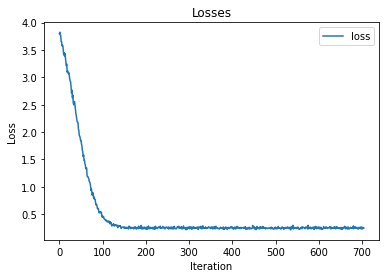

In [15]:
# change flag to False if you want only to test your losses w/o accuracy (it takes around 4-5 minutes)
q1_results(q1, True)

# Question 2. Barlow Twins

Here we will implement [barlow twins](https://arxiv.org/abs/2103.03230).

* You can use same architechure as in practice. 

* Dataset comes untransformed, so you need to apply transformations during training by yourself. Use same augmentations as in SimCLR

**Hyperparameters**

* λ = 0.01 
* lr = 5e-4
* num_epochs = 20
* latent dim = 128



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [ ]:
def q2(train_data):
    """
    train_data: An (n_train, 1, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """

In [ ]:
# change flag to False if you want only to test your losses w/o accuracy (it takes around 4-5 minutes)
q2_results(q2, True)

# Bonus. SwAV

Here we will implement [SwAV](https://arxiv.org/abs/2006.09882v5)

**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [ ]:
def b(train_data):
    """
    train_data: An (n_train, 1, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """

In [ ]:
q2_results(b, True)